In [23]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
# from google.colab.patches import cv2_imshow

In [24]:
def increase_contrast(image):
    # Apply linear contrast stretching
    min_val, max_val = np.min(image), np.max(image)
    contrast_image = (image - min_val) * (255 / (max_val - min_val))
    contrast_image = np.uint8(contrast_image)  # Convert back to uint8 type

    return contrast_image
def calc_avg_intensity(image):
    return np.mean(image)

def apply_dynamic_threshold(image, avg_intensity):
    if (avg_intensity>120 and avg_intensity<130 ): #check if gray compressed (only one that causes issues with threshold is gray compressed)
      image = increase_contrast(image)
      avg_intensity = calc_avg_intensity(image)

    threshold_value = int(avg_intensity * 0.75)
    _, thresholded_image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
    return thresholded_image

In [25]:
def detect_salt_and_pepper_noise(image, black_threshold=20, white_threshold=80):
    total_pixels = image.size
    black_pixels = np.sum(image == 0)
    white_pixels = np.sum(image == 255)

    black_ratio = black_pixels / total_pixels * 100
    white_ratio = white_pixels / total_pixels * 100

    if black_ratio > black_threshold or white_ratio < white_threshold:
        return True

    return False

In [26]:
def plot_time_domain(image_path, row=None, col=None):
    """
    Plots the time-domain representation of pixel intensities from an image.

    Args:
        image_path (str): Path to the input image.
        row (int, optional): Row index to extract pixel intensities. If None, the middle row is used.
        col (int, optional): Column index to extract pixel intensities. If None, the middle column is used.
    """
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Image not found or unable to load!")

    # Get image dimensions
    rows, cols = image.shape

    # Determine which row or column to extract
    if row is None and col is None:
        row = rows // 2  # Default to the middle row
    elif row is not None and (row < 0 or row >= rows):
        raise ValueError(f"Row index out of bounds. Must be between 0 and {rows - 1}.")
    elif col is not None and (col < 0 or col >= cols):
        raise ValueError(f"Column index out of bounds. Must be between 0 and {cols - 1}.")

    # Extract the pixel intensities
    if row is not None:
        intensities = image[row, :]  # Pixel intensities from the row
        x = np.arange(cols)  # X-axis: column indices
        label = f"Row {row}"
    else:
        intensities = image[:, col]  # Pixel intensities from the column
        x = np.arange(rows)  # X-axis: row indices
        label = f"Column {col}"


    return intensities

In [27]:
def analyze_peaks(signal, height=None, distance=50, tolerance=5, sampling_rate=1.0, plot=True):
    """
    Analyzes peaks in the time-domain signal and computes frequency domain characteristics.
    Returns the filter type based on the detected dominant frequencies.
    """
    # Dynamically adjust height if not provided
    if height is None:
        height = np.mean(signal) + 0.5 * np.std(signal)

    # Detect peaks
    peaks, _ = find_peaks(signal, height=height, distance=distance)

    if len(peaks) == 0:
        print(
            "No peaks detected. Consider adjusting the 'height' or 'distance' parameters.")
        return {
            'peaks': [],
            'peak_distances': [],
            'are_distances_equal': False,
            'dominant_frequencies': [],
            'magnitudes': [],
            'filter_type': None  # No filter type if no peaks are detected
        }

    # Calculate peak distances
    peak_distances = np.diff(peaks)
    if len(peak_distances) > 0:
        are_distances_equal = np.allclose(peak_distances, peak_distances[0], atol=tolerance)
    else:
        are_distances_equal = False

    # Compute FFT
    fft_result = np.fft.fft(signal)
    fft_magnitude = np.abs(fft_result)
    fft_frequencies = np.fft.fftfreq(len(signal), d=1/sampling_rate)

    # Consider positive frequencies
    positive_frequencies = fft_frequencies[:len(signal)//2]
    positive_magnitude = fft_magnitude[:len(signal)//2]

    # Detect peaks in FFT magnitude
    fft_peaks, _ = find_peaks(
        positive_magnitude, height=np.mean(positive_magnitude))
    dominant_frequencies = positive_frequencies[fft_peaks]
    dominant_magnitudes = positive_magnitude[fft_peaks]


    filter_type = None  # Default filter type is None

    # Determine the filter type based on the dominant frequencies
    if dominant_frequencies.size > 0:
        if dominant_frequencies[0] * 10000 < 60:
            filter_type = "Low-pass"
            # print("Low Frequency: Low-pass filter likely used.")
        else:
            filter_type = "High-pass"
            # print("High Frequency: High-pass filter likely used.")
    else:
        filter_type = "Low-pass"  # Default to low-pass if no dominant frequencies

    # Return analysis results including the filter type
    return {
        'peaks': peaks,
        'peak_distances': peak_distances,
        'are_distances_equal': are_distances_equal,
        'dominant_frequencies': dominant_frequencies,
        'magnitudes': dominant_magnitudes,
        'filter_type': filter_type
    }


In [28]:
def are_peaks_equally_spaced(signal, height=None, distance=50, tolerance=5):
    """
    Checks if the spaces (differences) between peaks in the given signal are approximately equal.

    Parameters:
        signal (numpy array): The input time-domain signal (1D array).
        height (float): Minimum height for a point to be considered a peak. Default is 150.
        distance (int): Minimum distance between consecutive peaks. Default is 50.
        tolerance (int): Allowed deviation for equal distances. Default is 5.

    Returns:
        bool: True if the differences between consecutive peaks are approximately equal, False otherwise.
    """
    # Detect peaks
    peaks, _ = find_peaks(signal, height=height, distance=distance)

    # Calculate peak distances
    peak_distances = np.diff(peaks)

    # Check if all distances are approximately equal
    if len(peak_distances) > 0:
        return np.allclose(peak_distances, peak_distances[0], atol=tolerance)
    else:
        return False

In [29]:
def give_me_circle_mask_nowww(mask_size, radius):
    mask = np.zeros(mask_size)
    cy = mask.shape[0] // 2
    cx = mask.shape[1] // 2
    return cv2.circle(mask, (cx, cy), radius, (255, 255, 255), -1).astype(np.uint8)

def plot_shifted_fft_and_ifft(dft_img_shifted):
    img = np.fft.ifft2(np.fft.ifftshift(dft_img_shifted))
    img = np.abs(img)  # Get magnitude
    img = img.astype(np.uint16)
    return img

def try_highpass(dft_img, limit, gaussian: bool = False, keep_dc: bool = False):
    mask = ~give_me_circle_mask_nowww(dft_img.shape, limit)
    if (gaussian):
        mask = cv2.GaussianBlur(mask, (21, 21), 0)
    if (keep_dc):
        mask[dft_img.shape[0]//2, dft_img.shape[1]//2] = 255
    dft_img_shifted = np.fft.fftshift(dft_img)
    dft_img_shifted_highpass = np.multiply(dft_img_shifted, mask)
    freqimg = plot_shifted_fft_and_ifft(dft_img_shifted_highpass)
    return freqimg


def try_lowpass(dft_img, limit, gaussian: bool = False):
    mask = give_me_circle_mask_nowww(dft_img.shape, limit)
    if (gaussian):
        mask = cv2.GaussianBlur(mask, (21, 21), 0)
    dft_img_shifted = np.fft.fftshift(dft_img)
    dft_img_shifted_lowpass = np.multiply(dft_img_shifted, mask)
    freqimg = plot_shifted_fft_and_ifft(dft_img_shifted_lowpass)
    return freqimg

In [30]:
def detect_and_normalize_bar_sizes(pixels, narrow_bar_size, wide_bar_size,):
    bar_widths = []
    current_width = 1
    current_pixel = pixels[0]
    # loop through the pixels and count the width of each bar
    for pixel in pixels[1:]:
        if pixel == current_pixel:
            current_width += 1
        else:
            bar_widths.append((current_pixel, current_width))
            current_width = 1
            current_pixel = pixel

    if current_width > 0:
        bar_widths.append((current_pixel, current_width))

    # calculate average width of the bars
    average = sum(width for _, width in bar_widths) / len(bar_widths)
    normalized_pixels = []
    # loop through the bar widths and normalize them
    for pixel, width in bar_widths:
        if width <= narrow_bar_size:
            normalized_pixels.append((pixel, narrow_bar_size))
        elif width > narrow_bar_size:
            if width <= average:
                normalized_pixels.append((pixel, narrow_bar_size))
            elif average < width:
                normalized_pixels.extend([(pixel, wide_bar_size)])
            else:
                print("Invalid barcode")
                break
        else:
            print("Invalid barcode")
            break
    # convert the normalized pixels to a string
    normalized_pixel_str = ''.join(
        ('1' * width) if pixel == '1' else ('0' * width) for pixel, width in normalized_pixels)

    return normalized_pixel_str


def decode_barcode():
    # 0 means narrow, 1 means wide
    NARROW = "0"
    WIDE = "1"
    code11_widths = {
        "00110": "Stop/Start",
        "10001": "1",
        "01001": "2",
        "11000": "3",
        "00101": "4",
        "10100": "5",
        "01100": "6",
        "00011": "7",
        "10010": "8",
        "10000": "9",
        "00001": "0",
        "00100": "-",
    }
    img = cv2.imread("FinalImage.jpg", cv2.IMREAD_GRAYSCALE)
    # Get the average of each column in your image
    mean = img.mean(axis=0)
    # Set it to black or white based on its value
    mean[mean <= 127] = 1
    mean[mean > 128] = 0
    # Convert to string of pixels in order to loop over it
    pixels = ''.join(mean.astype(np.uint8).astype(str))

    # Need to figure out how many pixels represent a narrow bar
    narrow_bar_size = 0
    for pixel in pixels:
        if pixel == "1":
            narrow_bar_size += 1
        else:
            break

    wide_bar_size = narrow_bar_size * 2

    # Normalize the bar sizes
    pixels = detect_and_normalize_bar_sizes(
        pixels, narrow_bar_size, wide_bar_size)

    digits = []
    pixel_index = 0
    current_digit_widths = ""
    skip_next = False
    while pixel_index < len(pixels):

        if skip_next:
            pixel_index += narrow_bar_size
            skip_next = False
            continue
        count = 1
        try:                                                    
            while pixels[pixel_index] == pixels[pixel_index + 1]:
                count += 1
                pixel_index += 1
        except:
            pass
        pixel_index += 1
        current_digit_widths += NARROW if count == narrow_bar_size else WIDE
        if current_digit_widths in code11_widths:
            digits.append(code11_widths[current_digit_widths])
            current_digit_widths = ""
            skip_next = True  # Next iteration will be a separator, so skip it
    print("--------------------------------------------")
    print("Detected barcode is:")
    print("--------------------")
    print(digits)

In [31]:
def remove_initial_whites(pixels):
    # Find the first black pixel
    first_black_index = pixels.find('1')
    if first_black_index == -1:
        return "", 0
    #return the pixels starting from the first black pixel , first black pixel index
    return pixels[first_black_index:] ,first_black_index


def make_columns_uniform(image):
    #set height , width and number of parts each column will be spilt into
    height, width = image.shape
    num_parts = 10
    part_height = height // num_parts

    # Loop through each column
    for x in range(width):
        part_most_common = []

        # Loop through each part of the column
        for part in range(num_parts):
            # Get the pixels in the part
            start_idx = part * part_height
            end_idx = (part + 1) * part_height if part != num_parts - 1 else height
            part_pixels = image[start_idx:end_idx, x]

            # Find most common pixel values in the part (the sorted unique elements of the array and their counts)
            unique, counts = np.unique(part_pixels, return_counts=True)

            # set common pixels to black (0) or white (255) based on their value
            for idx, item in enumerate(unique):
                if item >= 128:
                    unique[idx] = 255
                else:
                    unique[idx] = 0
            # find most repeated pixel value in the part and append it to the part_most_common list
            # so that later we can find the most common column value after looping through all parts
            mode_pixel = unique[np.argmax(counts)]
            part_most_common.append(mode_pixel)

        # Determine the most common value among all the parts
        final_unique, final_counts = np.unique(part_most_common, return_counts=True)
        most_common_pixel = final_unique[np.argmax(final_counts)]

        # Set all pixels in the column to the most common value
        image[:, x] = most_common_pixel


    return image

# This function reorder the corners points appropriatly
# Helped significantly with warp function
def reorder(myPoints):
    myPoints = myPoints.reshape((4, 2))
    myPointsNew = np.zeros((4, 1, 2), dtype=np.int32)
    add = myPoints.sum(1)
    myPointsNew[1] = myPoints[np.argmin(add)]
    myPointsNew[3] = myPoints[np.argmax(add)]
    diff = np.diff(myPoints, axis=1)
    myPointsNew[0] = myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]
    return myPointsNew

def detect_barcode(image):



    # blur before sobel
    blurred = cv2.GaussianBlur(image, (5, 5),0)
    # compute the Scharr gradient magnitude representation of the images in both the x and y direction
    gradX = cv2.Sobel(blurred, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = -1)
    gradY = cv2.Sobel(blurred, ddepth = cv2.CV_32F, dx = 0, dy = 1, ksize = -1)



    # subtract the y-gradient from the x-gradient
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)
    # blur and threshold the image
    blurred = cv2.blur(gradient, (9, 9))
    (_, thresh) = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)


    # construct a closing kernel and apply it to the thresholded image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # perform a series of erosions and dilations
    closed = cv2.erode(closed, None, iterations = 4)

    closed = cv2.dilate(closed, None, iterations = 4)

    # find the contours in the thresholded image,
    #  then sort the contours by their area,
    #  keeping only the largest one
    (cnts, _) = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnt = sorted(cnts, key = cv2.contourArea, reverse = True)[0]

    if cv2.contourArea(cnt) > 0:  # Check if contour is valid

        # compute the rotated bounding box of the largest contour
        rect = cv2.minAreaRect(cnt)
        box = np.int32(cv2.boxPoints(rect))
        box = reorder(box)


        # Coordinates of each corner
        ax = box.item(0)
        ay = box.item(1)

        bx = box.item(2)
        by = box.item(3)

        cx = box.item(4)
        cy = box.item(5)

        dx = box.item(6)
        dy = box.item(7)

        # find the width and height of the rectangle from the corners
        widthA = np.sqrt(((cx - dx) ** 2) + ((cy - dy) ** 2))
        widthB = np.sqrt(((ax - bx) ** 2) + ((ay - by) ** 2))
        width = max(int(widthA), int(widthB))

        heightA = np.sqrt(((ax - dx) ** 2) + ((ay - dy) ** 2))
        heightB = np.sqrt(((bx - cx) ** 2) + ((by - cy) ** 2))
        height = max(int(heightA), int(heightB))

        
        pts1 = np.float32([[bx, by], [ax, ay], [cx, cy], [dx, dy]])
        pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])

        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        img_prespective = cv2.warpPerspective(image, matrix, (width, height))

        # remove anomalies/remaining noise in the image (set all column pixels to either black or white)
        uniform_image = make_columns_uniform(img_prespective)
        # save the image to UniformImage.jpg
        cv2.imwrite("UniformImage.jpg", uniform_image)
        
        # read the image to do one last check for possible problems
        img = cv2.imread("UniformImage.jpg", cv2.IMREAD_GRAYSCALE)
        
        # Get the average of each column in your image
        mean = img.mean(axis=0)

        # Set it to black or white based on its value
        mean[mean <= 127] = 1
        mean[mean > 128] = 0

        # Convert to string of pixels in order to loop over it
        pixels = ''.join(mean.astype(np.uint8).astype(str))
        # call the function to remove initial white parts of the barcode
        pixels , ignore= remove_initial_whites(pixels)
        # after getting the first black pixel, store the image starting from that pixel
        image_modified = img[ignore:, ignore:]
        # save the image to FinalImage.jpg
        cv2.imwrite("FinalImage.jpg", image_modified)
        # show the image
        plt.imshow(image_modified, cmap='gray')
        plt.axis('off')
        plt.show()
        # call the decoding function
        decoded_digits = decode_barcode()
        print(decoded_digits)
        cv2.waitKey(0)
    else:
        print("No barcode detected")
        cv2.waitKey(0)


In [32]:
def preprocessing(img , image_path):

    avg_intensity =calc_avg_intensity(img)
    thresh = apply_dynamic_threshold(img, avg_intensity)
    is_salt_pepper =detect_salt_and_pepper_noise(thresh)

    if is_salt_pepper:
        intensities =plot_time_domain(image_path,300,300)
        # Call the function
        results = analyze_peaks(intensities, height=150, distance=50, tolerance=5)
        peaks_equally_spaced = are_peaks_equally_spaced(intensities,height = 150)
        # Output results


        if peaks_equally_spaced:
            dft_img = np.fft.fft2(img)
            if results['filter_type'] == "High-pass":
                freqimg = try_highpass(dft_img, 20, gaussian=False, keep_dc=True)
                # If try_highpass produces complex numbers, extract magnitude
                freqimg = np.abs(freqimg)
                # Ensure the image is in a uint8 format (0-255) for OpenCV compatibility
                freqimg = np.uint8(255 * (freqimg / np.max(freqimg)))  # Normalize to 0-255
                # If needed, ensure single-channel image
                if len(freqimg.shape) > 2:
                    freqimg = cv2.cvtColor(freqimg, cv2.COLOR_BGR2GRAY)
                contrast =increase_contrast(freqimg)
                detect_barcode(contrast)
                plt.imshow(freqimg,cmap='gray')

            elif results['filter_type'] == "Low-pass":
                freqimg = try_lowpass(dft_img, 150, gaussian=True)
                # If try_highpass produces complex numbers, extract magnitude
                freqimg = np.abs(freqimg)
                # Ensure the image is in a uint8 format (0-255) for OpenCV compatibility
                # Normalize to 0-255
                freqimg = np.uint8(255 * (freqimg / np.max(freqimg)))
                # If needed, ensure single-channel image
                if len(freqimg.shape) > 2:
                    freqimg = cv2.cvtColor(freqimg, cv2.COLOR_BGR2GRAY)
                contrast = increase_contrast(freqimg)
                detect_barcode(contrast)
                plt.imshow(freqimg, cmap='gray')
        else:
            avg_intensity =calc_avg_intensity(img)
            thresholded_image = apply_dynamic_threshold(img,avg_intensity)
            kernel = np.ones((3, 3), np.uint8)
            dil_img = cv2.dilate(thresholded_image, kernel, iterations=1)
            erode_img = cv2.erode(dil_img, kernel, iterations=1)

            detect_barcode(erode_img)
    else:
        print("No Salt and Pepper Noise")

        avg_intensity =calc_avg_intensity(img)
        brightness_threshold = 250

        # Check if the image is too bright , as these functions will increase its noise
        if avg_intensity < brightness_threshold:
            thresholded_image = apply_dynamic_threshold(img,avg_intensity)
            kernel = np.ones((3, 3), np.uint8)
            dil_img = cv2.dilate(thresholded_image, kernel, iterations=1)
            erode_img = cv2.erode(dil_img, kernel, iterations=1)
            result =increase_contrast(erode_img)
            detect_barcode(result)
        else:
            result =increase_contrast(img)
            detect_barcode(result)

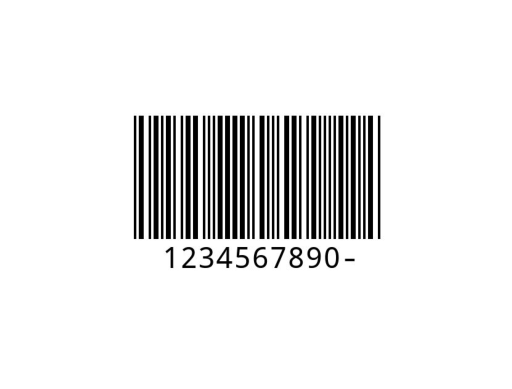

No Salt and Pepper Noise


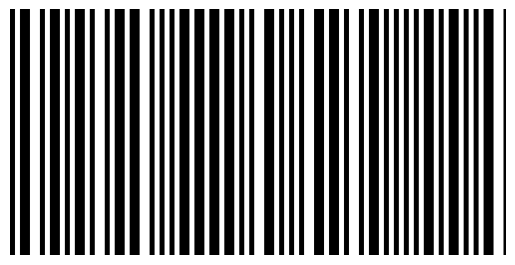

--------------------------------------------
Detected barcode is:
--------------------
['Stop/Start', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '-', 'Stop/Start']
None


In [33]:
# --------------------------------------------MAIN--------------------------------
# --------------------------------------------Test Case - 1--------------------------------

# Uncomment the needed Test Case

image_path ='Test Cases/01 - lol easy.jpg' 
# image_path ='Test Cases/02 - still easy.jpg' 
# image_path ='Test Cases/03 - eda ya3am ew3a soba3ak mathazarsh.jpg' 
# image_path ='Test Cases/04 - fen el nadara.jpg' 
# image_path ='Test Cases/05 - meen taffa el nour!!!.jpg' 
# image_path ='Test Cases/06 - meen fata7 el nour 333eenaaayy.jpg' 
# image_path ='Test Cases/07 - mal7 w felfel.jpg' 
# image_path ='Test Cases/08 - compresso espresso.jpg' 
# image_path ='Test Cases/09 - e3del el soora ya3ammm.jpg' 
# image_path ='Test Cases/10 - wen el kontraastttt.jpg' 
# image_path ='Test Cases/11 - bayza 5ales di bsara7a.jpg' 

img = cv2.imread(image_path, 0)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
# cv2.imshow("Original Image", img)
preprocessing(img, image_path)

cv2.waitKey(0)
cv2.destroyAllWindows()

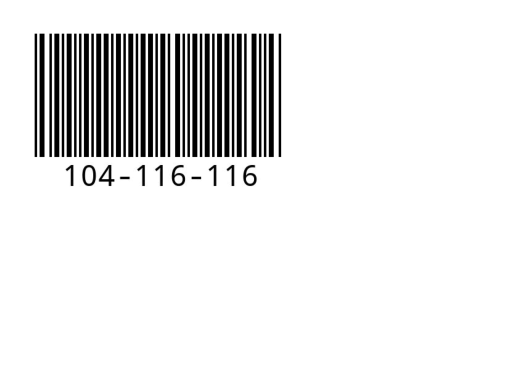

No Salt and Pepper Noise


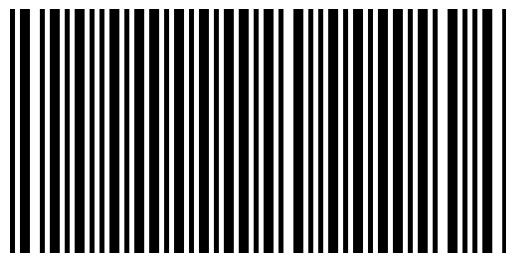

--------------------------------------------
Detected barcode is:
--------------------
['Stop/Start', '1', '0', '4', '-', '1', '1', '6', '-', '1', '1', '6', 'Stop/Start']
None


In [34]:
# --------------------------------------------MAIN--------------------------------
# --------------------------------------------Test Case - 2--------------------------------

# Uncomment the needed Test Case

# image_path = 'Test Cases/01 - lol easy.jpg'
image_path ='Test Cases/02 - still easy.jpg'
# image_path ='Test Cases/03 - eda ya3am ew3a soba3ak mathazarsh.jpg'
# image_path ='Test Cases/04 - fen el nadara.jpg'
# image_path ='Test Cases/05 - meen taffa el nour!!!.jpg'
# image_path ='Test Cases/06 - meen fata7 el nour 333eenaaayy.jpg'
# image_path ='Test Cases/07 - mal7 w felfel.jpg'
# image_path ='Test Cases/08 - compresso espresso.jpg'
# image_path ='Test Cases/09 - e3del el soora ya3ammm.jpg'
# image_path ='Test Cases/10 - wen el kontraastttt.jpg'
# image_path ='Test Cases/11 - bayza 5ales di bsara7a.jpg'

img = cv2.imread(image_path, 0)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
# cv2.imshow("Original Image", img)
preprocessing(img, image_path)

cv2.waitKey(0)
cv2.destroyAllWindows()

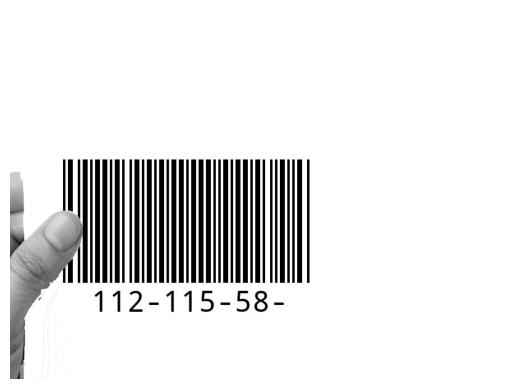

No Salt and Pepper Noise


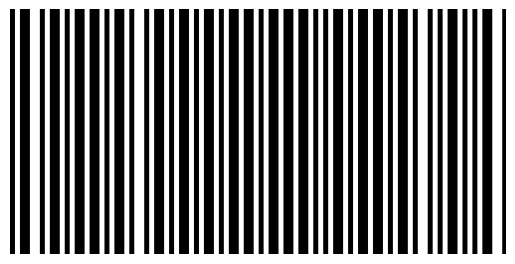

--------------------------------------------
Detected barcode is:
--------------------
['Stop/Start', '1', '1', '2', '-', '1', '1', '5', '-', '5', '8', '-', 'Stop/Start']
None


In [35]:
# --------------------------------------------MAIN--------------------------------
# --------------------------------------------Test Case - 3--------------------------------

# Uncomment the needed Test Case

# image_path = 'Test Cases/01 - lol easy.jpg'
# image_path ='Test Cases/02 - still easy.jpg'
image_path ='Test Cases/03 - eda ya3am ew3a soba3ak mathazarsh.jpg'
# image_path ='Test Cases/04 - fen el nadara.jpg'
# image_path ='Test Cases/05 - meen taffa el nour!!!.jpg'
# image_path ='Test Cases/06 - meen fata7 el nour 333eenaaayy.jpg'
# image_path ='Test Cases/07 - mal7 w felfel.jpg'
# image_path ='Test Cases/08 - compresso espresso.jpg'
# image_path ='Test Cases/09 - e3del el soora ya3ammm.jpg'
# image_path ='Test Cases/10 - wen el kontraastttt.jpg'
# image_path ='Test Cases/11 - bayza 5ales di bsara7a.jpg'

img = cv2.imread(image_path, 0)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
# cv2.imshow("Original Image", img)
preprocessing(img, image_path)

cv2.waitKey(0)
cv2.destroyAllWindows()

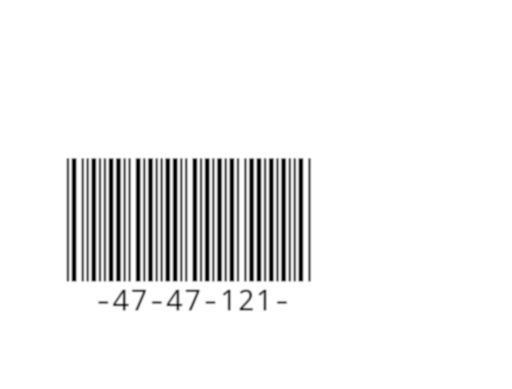

No Salt and Pepper Noise


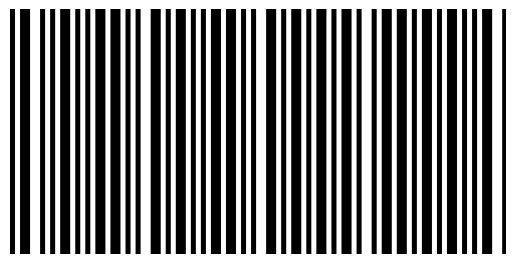

--------------------------------------------
Detected barcode is:
--------------------
['Stop/Start', '-', '4', '7', '-', '4', '7', '-', '1', '2', '1', '-', 'Stop/Start']
None


In [36]:
# --------------------------------------------MAIN--------------------------------
# --------------------------------------------Test Case - 4--------------------------------

# Uncomment the needed Test Case

# image_path = 'Test Cases/01 - lol easy.jpg'
# image_path ='Test Cases/02 - still easy.jpg'
# image_path ='Test Cases/03 - eda ya3am ew3a soba3ak mathazarsh.jpg'
image_path ='Test Cases/04 - fen el nadara.jpg'
# image_path ='Test Cases/05 - meen taffa el nour!!!.jpg'
# image_path ='Test Cases/06 - meen fata7 el nour 333eenaaayy.jpg'
# image_path ='Test Cases/07 - mal7 w felfel.jpg'
# image_path ='Test Cases/08 - compresso espresso.jpg'
# image_path ='Test Cases/09 - e3del el soora ya3ammm.jpg'
# image_path ='Test Cases/10 - wen el kontraastttt.jpg'
# image_path ='Test Cases/11 - bayza 5ales di bsara7a.jpg'

img = cv2.imread(image_path, 0)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
# cv2.imshow("Original Image", img)
preprocessing(img, image_path)

cv2.waitKey(0)
cv2.destroyAllWindows()

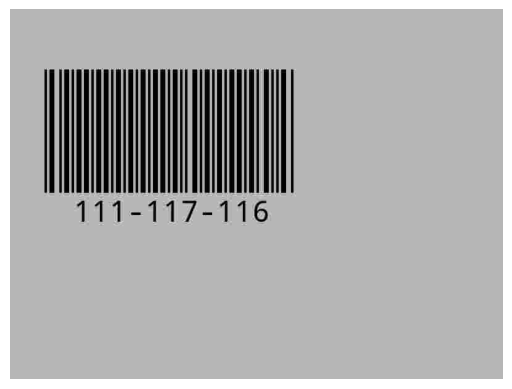

No Salt and Pepper Noise


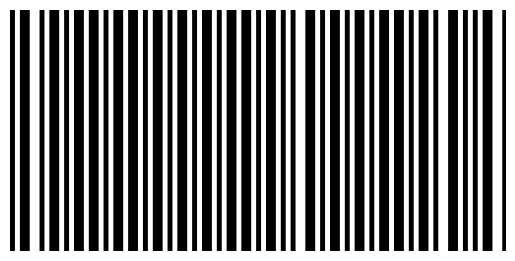

--------------------------------------------
Detected barcode is:
--------------------
['Stop/Start', '1', '1', '1', '-', '1', '1', '7', '-', '1', '1', '6', 'Stop/Start']
None


In [37]:
# --------------------------------------------MAIN--------------------------------
# --------------------------------------------Test Case - 5--------------------------------

# Uncomment the needed Test Case

# image_path = 'Test Cases/01 - lol easy.jpg'
# image_path ='Test Cases/02 - still easy.jpg'
# image_path ='Test Cases/03 - eda ya3am ew3a soba3ak mathazarsh.jpg'
# image_path ='Test Cases/04 - fen el nadara.jpg'
image_path ='Test Cases/05 - meen taffa el nour!!!.jpg'
# image_path ='Test Cases/06 - meen fata7 el nour 333eenaaayy.jpg'
# image_path ='Test Cases/07 - mal7 w felfel.jpg'
# image_path ='Test Cases/08 - compresso espresso.jpg'
# image_path ='Test Cases/09 - e3del el soora ya3ammm.jpg'
# image_path ='Test Cases/10 - wen el kontraastttt.jpg'
# image_path ='Test Cases/11 - bayza 5ales di bsara7a.jpg'

img = cv2.imread(image_path, 0)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
# cv2.imshow("Original Image", img)
preprocessing(img, image_path)

cv2.waitKey(0)
cv2.destroyAllWindows()

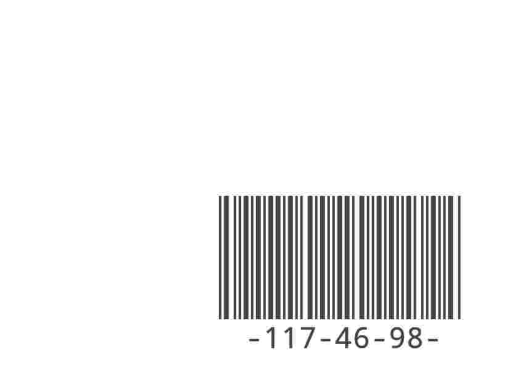

No Salt and Pepper Noise


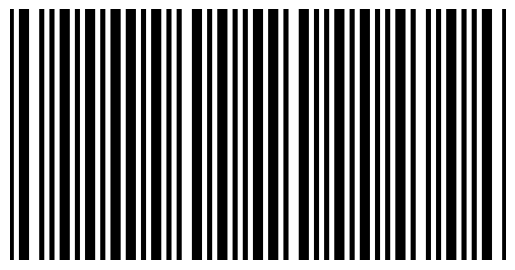

--------------------------------------------
Detected barcode is:
--------------------
['Stop/Start', '-', '1', '1', '7', '-', '4', '6', '-', '9', '8', '-', 'Stop/Start']
None


In [38]:
# --------------------------------------------MAIN--------------------------------
# --------------------------------------------Test Case - 6--------------------------------

# Uncomment the needed Test Case

# image_path = 'Test Cases/01 - lol easy.jpg'
# image_path ='Test Cases/02 - still easy.jpg'
# image_path ='Test Cases/03 - eda ya3am ew3a soba3ak mathazarsh.jpg'
# image_path ='Test Cases/04 - fen el nadara.jpg'
# image_path ='Test Cases/05 - meen taffa el nour!!!.jpg'
image_path ='Test Cases/06 - meen fata7 el nour 333eenaaayy.jpg'
# image_path ='Test Cases/07 - mal7 w felfel.jpg'
# image_path ='Test Cases/08 - compresso espresso.jpg'
# image_path ='Test Cases/09 - e3del el soora ya3ammm.jpg'
# image_path ='Test Cases/10 - wen el kontraastttt.jpg'
# image_path ='Test Cases/11 - bayza 5ales di bsara7a.jpg'

img = cv2.imread(image_path, 0)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
# cv2.imshow("Original Image", img)
preprocessing(img, image_path)

cv2.waitKey(0)
cv2.destroyAllWindows()

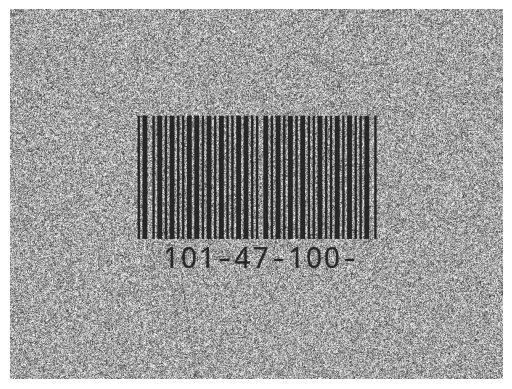

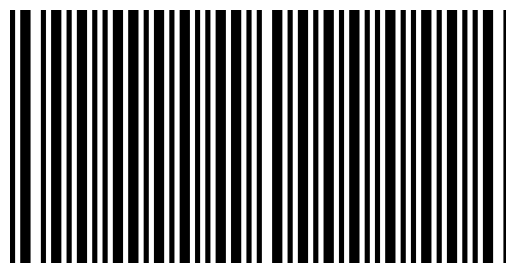

--------------------------------------------
Detected barcode is:
--------------------
['Stop/Start', '1', '0', '1', '-', '4', '7', '-', '1', '0', '0', '-', 'Stop/Start']
None


In [39]:
# --------------------------------------------MAIN--------------------------------
# --------------------------------------------Test Case - 7--------------------------------

# Uncomment the needed Test Case

# image_path = 'Test Cases/01 - lol easy.jpg'
# image_path ='Test Cases/02 - still easy.jpg'
# image_path ='Test Cases/03 - eda ya3am ew3a soba3ak mathazarsh.jpg'
# image_path ='Test Cases/04 - fen el nadara.jpg'
# image_path ='Test Cases/05 - meen taffa el nour!!!.jpg'
# image_path ='Test Cases/06 - meen fata7 el nour 333eenaaayy.jpg'
image_path ='Test Cases/07 - mal7 w felfel.jpg'
# image_path ='Test Cases/08 - compresso espresso.jpg'
# image_path ='Test Cases/09 - e3del el soora ya3ammm.jpg'
# image_path ='Test Cases/10 - wen el kontraastttt.jpg'
# image_path ='Test Cases/11 - bayza 5ales di bsara7a.jpg'

img = cv2.imread(image_path, 0)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
# cv2.imshow("Original Image", img)
preprocessing(img, image_path)

cv2.waitKey(0)
cv2.destroyAllWindows()

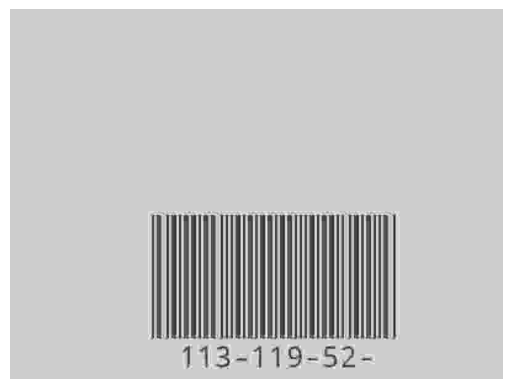

No Salt and Pepper Noise


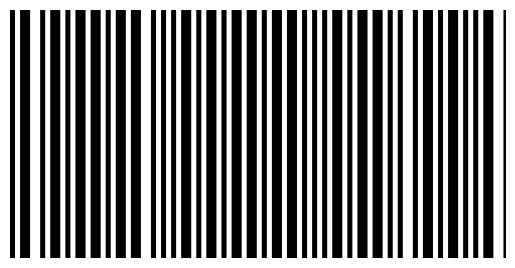

--------------------------------------------
Detected barcode is:
--------------------
['Stop/Start', '1', '1', '3', '-', '1', '1', '9', '-', '5', '2', '-', 'Stop/Start']
None


In [40]:
# --------------------------------------------MAIN--------------------------------
# --------------------------------------------Test Case - 8--------------------------------

# Uncomment the needed Test Case

# image_path = 'Test Cases/01 - lol easy.jpg'
# image_path ='Test Cases/02 - still easy.jpg'
# image_path ='Test Cases/03 - eda ya3am ew3a soba3ak mathazarsh.jpg'
# image_path ='Test Cases/04 - fen el nadara.jpg'
# image_path ='Test Cases/05 - meen taffa el nour!!!.jpg'
# image_path ='Test Cases/06 - meen fata7 el nour 333eenaaayy.jpg'
# image_path ='Test Cases/07 - mal7 w felfel.jpg'
image_path ='Test Cases/08 - compresso espresso.jpg'
# image_path ='Test Cases/09 - e3del el soora ya3ammm.jpg'
# image_path ='Test Cases/10 - wen el kontraastttt.jpg'
# image_path ='Test Cases/11 - bayza 5ales di bsara7a.jpg'

img = cv2.imread(image_path, 0)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
# cv2.imshow("Original Image", img)
preprocessing(img, image_path)

cv2.waitKey(0)
cv2.destroyAllWindows()

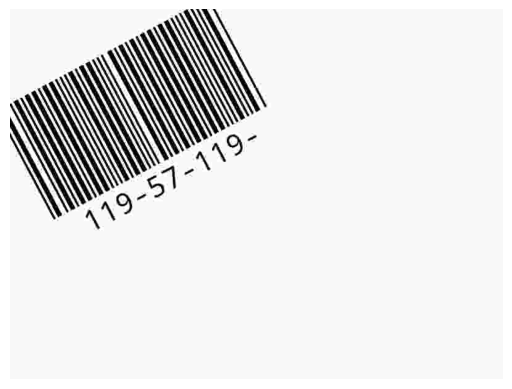

No Salt and Pepper Noise


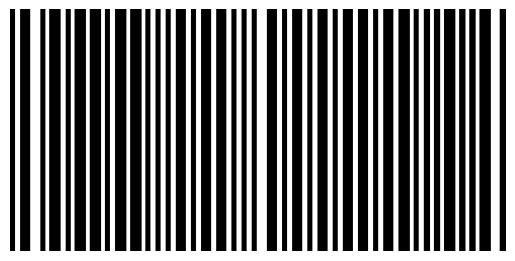

--------------------------------------------
Detected barcode is:
--------------------
['Stop/Start', '1', '1', '9', '-', '5', '7', '-', '1', '1', '9', '-', 'Stop/Start']
None


In [41]:
# --------------------------------------------MAIN--------------------------------
# --------------------------------------------Test Case - 9 --------------------------------

# Uncomment the needed Test Case

# image_path = 'Test Cases/01 - lol easy.jpg'
# image_path ='Test Cases/02 - still easy.jpg'
# image_path ='Test Cases/03 - eda ya3am ew3a soba3ak mathazarsh.jpg'
# image_path ='Test Cases/04 - fen el nadara.jpg'
# image_path ='Test Cases/05 - meen taffa el nour!!!.jpg'
# image_path ='Test Cases/06 - meen fata7 el nour 333eenaaayy.jpg'
# image_path ='Test Cases/07 - mal7 w felfel.jpg'
# image_path ='Test Cases/08 - compresso espresso.jpg'
image_path ='Test Cases/09 - e3del el soora ya3ammm.jpg'
# image_path ='Test Cases/10 - wen el kontraastttt.jpg'
# image_path ='Test Cases/11 - bayza 5ales di bsara7a.jpg'

img = cv2.imread(image_path, 0)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
# cv2.imshow("Original Image", img)
preprocessing(img, image_path)

cv2.waitKey(0)
cv2.destroyAllWindows()

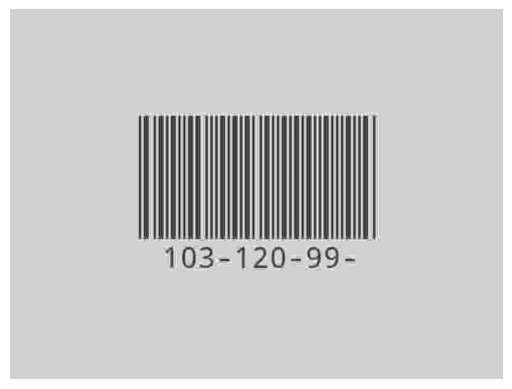

No Salt and Pepper Noise


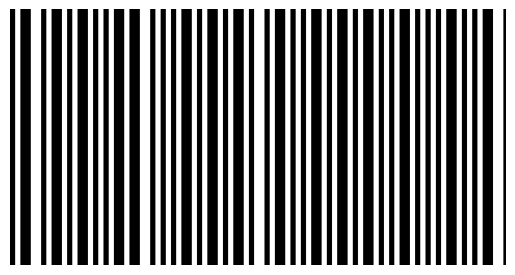

--------------------------------------------
Detected barcode is:
--------------------
['Stop/Start', '1', '0', '3', '-', '1', '2', '0', '-', '9', '9', '-', 'Stop/Start']
None


In [42]:
# --------------------------------------------MAIN--------------------------------
# --------------------------------------------Test Case - 10--------------------------------

# Uncomment the needed Test Case

# image_path = 'Test Cases/01 - lol easy.jpg'
# image_path ='Test Cases/02 - still easy.jpg'
# image_path ='Test Cases/03 - eda ya3am ew3a soba3ak mathazarsh.jpg'
# image_path ='Test Cases/04 - fen el nadara.jpg'
# image_path ='Test Cases/05 - meen taffa el nour!!!.jpg'
# image_path ='Test Cases/06 - meen fata7 el nour 333eenaaayy.jpg'
# image_path ='Test Cases/07 - mal7 w felfel.jpg'
# image_path ='Test Cases/08 - compresso espresso.jpg'
# image_path ='Test Cases/09 - e3del el soora ya3ammm.jpg'
image_path ='Test Cases/10 - wen el kontraastttt.jpg'
# image_path ='Test Cases/11 - bayza 5ales di bsara7a.jpg'

img = cv2.imread(image_path, 0)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
# cv2.imshow("Original Image", img)
preprocessing(img, image_path)

cv2.waitKey(0)
cv2.destroyAllWindows()

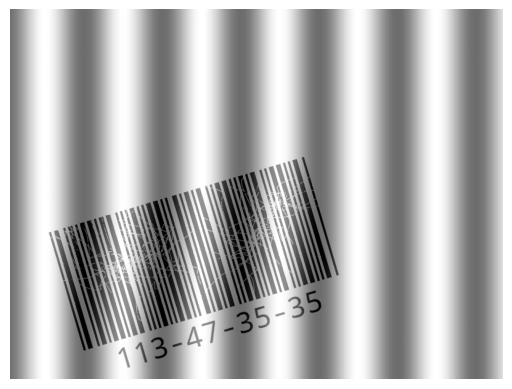

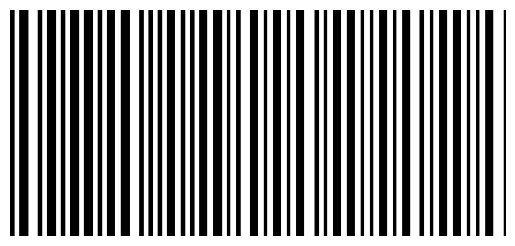

--------------------------------------------
Detected barcode is:
--------------------
['Stop/Start', '1', '1', '3', '-', '4', '7', '-', '3', '5', '-', '3', '5', 'Stop/Start']
None


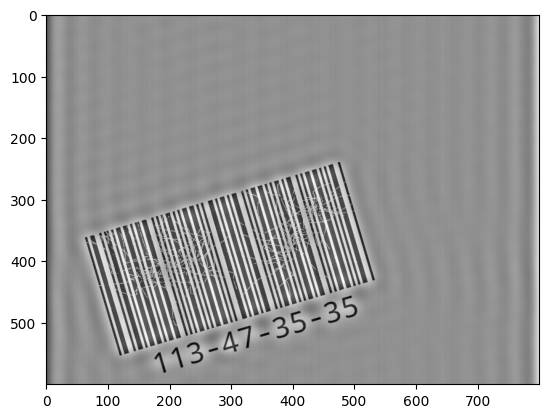

In [43]:
# --------------------------------------------MAIN--------------------------------
# --------------------------------------------Test Case - 11--------------------------------

# Uncomment the needed Test Case

# image_path = 'Test Cases/01 - lol easy.jpg'
# image_path ='Test Cases/02 - still easy.jpg'
# image_path ='Test Cases/03 - eda ya3am ew3a soba3ak mathazarsh.jpg'
# image_path ='Test Cases/04 - fen el nadara.jpg'
# image_path ='Test Cases/05 - meen taffa el nour!!!.jpg'
# image_path ='Test Cases/06 - meen fata7 el nour 333eenaaayy.jpg'
# image_path ='Test Cases/07 - mal7 w felfel.jpg'
# image_path ='Test Cases/08 - compresso espresso.jpg'
# image_path ='Test Cases/09 - e3del el soora ya3ammm.jpg'
# image_path ='Test Cases/10 - wen el kontraastttt.jpg'
image_path ='Test Cases/11 - bayza 5ales di bsara7a.jpg'

img = cv2.imread(image_path, 0)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
# cv2.imshow("Original Image", img)
preprocessing(img, image_path)

cv2.waitKey(0)
cv2.destroyAllWindows()